In [205]:
# imports
import os
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import sklearn
from sklearn import decomposition, cluster, manifold
from sklearn.linear_model import LinearRegression as linreg



import TwoPUtils



%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
with open("/home/mplitt/2P_scratch/all_session_dict.pkl","rb") as f:
    all_sessions = pickle.load(f)

In [174]:
print(all_sessions['GRABDA7'][2])

{'date': '12_12_2020', 'scene': 'NeuroMods_LocationA', 'session': 2, 'scan': 2}


In [217]:
mouse = "GRABDA5"
ind = 2

f = all_sessions[mouse][ind]
f['mouse']=mouse


scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
try:
    source_folder  = os.path.join('/media/mplitt','Backup Plus')
    source_stem = os.path.join(source_folder,f['mouse'],f['date'],f['scene'],scan_str)
    info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
except:
    source_folder  = os.path.join('/media/mplitt','Backup Plus1','2P_Data')
    source_stem = os.path.join(source_folder,f['mouse'],f['date'],f['scene'],scan_str)
    info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')

f.update({'scan_file': source_stem + '.sbx',
          'scanheader_file': source_stem + '.mat',
          'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
          'scan_number': f['scan'],
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
         })
if f['mouse'] == 'GRABDA6':
    f['s2p_path']=os.path.join("/home/mplitt/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')
else:
    f['s2p_path']=os.path.join("/mnt/BigDisk/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')
    
print(f)


{'date': '12_12_2020', 'scene': 'NeuroMods_LocationA', 'session': 2, 'scan': 3, 'mouse': 'GRABDA5', 'scan_file': '/media/mplitt/Backup Plus/GRABDA5/12_12_2020/NeuroMods_LocationA/NeuroMods_LocationA_002_003.sbx', 'scanheader_file': '/media/mplitt/Backup Plus/GRABDA5/12_12_2020/NeuroMods_LocationA/NeuroMods_LocationA_002_003.mat', 'vr_filename': '/home/mplitt/VR_scratch/GRABDA5/12_12_2020/NeuroMods_LocationA_2.sqlite', 'scan_number': 3, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 's2p_path': '/mnt/BigDisk/2P_scratch/GRABDA5/12_12_2020/NeuroMods_LocationA/NeuroMods_LocationA_002_003/suite2p'}


In [218]:
sess = TwoPUtils.sess.Session(**f)
sess.load_scan_info()
sess.align_VR_to_2P()
sess.load_suite2p_data()
sess.add_timeseries(licks=sess.vr_data['lick'],rewards=sess.vr_data['reward'])
sess.add_pos_binned_trial_matrix(['licks','rewards'],'pos')



/home/mplitt/repos/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")
/home/mplitt/repos/TwoPUtils/preprocessing.py:134: RuntimeWarning: divide by zero encountered in remainder
  lines = np.array([l % scan_info['fold_lines'] for l in scan_info['line']])


1603.3309752400203 1603.2662961091462


/home/mplitt/repos/TwoPUtils/sess.py:390: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v = v[np.newaxis, :]


In [219]:
# calculate place cells
#regress green channel from red channel

F = np.zeros(sess.timeseries['F'].shape)*np.nan
F2 = np.zeros(sess.timeseries['F'].shape)*np.nan

Fneu = np.zeros(sess.timeseries['F'].shape)*np.nan
Fneu2 = np.zeros(sess.timeseries['F'].shape)*np.nan
for i, (start,stop) in enumerate(zip(sess.trial_start_inds.tolist(),sess.teleport_inds.tolist())):
    F[:,start-1:stop-1] = sess.timeseries['F'][:,start-1:stop-1]
    F2[:,start-1:stop-1] = sess.timeseries['F_chan2'][:,start-1:stop-1]
    
    Fneu[:,start-1:stop-1] = sess.timeseries['Fneu'][:,start-1:stop-1]
    Fneu2[:,start-1:stop-1] = sess.timeseries['Fneu_chan2'][:,start-1:stop-1]
    
nanmask = ~np.isnan(F[0,:])
print(nanmask.sum())
for cell in range(F.shape[0]):
    lr = linreg().fit(F2[cell:cell+1,nanmask].T,F[cell,nanmask])
    F[cell,nanmask] = F[cell,nanmask]-lr.predict(F2[cell:cell+1,nanmask].T) + lr.intercept_
    
    lr = linreg().fit(Fneu2[cell:cell+1,nanmask].T,Fneu[cell,nanmask])
    Fneu[cell,nanmask] = Fneu[cell,nanmask]-lr.predict(Fneu2[cell:cell+1,nanmask].T) + lr.intercept_
    
F -= .7*Fneu
F2 -= .7*Fneu2
    


Flow = sp.ndimage.filters.gaussian_filter(F[:,nanmask],    [0., 15])
Flow = sp.ndimage.filters.minimum_filter1d(Flow,    int(500*15))
Flow = sp.ndimage.filters.maximum_filter1d(Flow,    int(500*15))
dFF = np.zeros(sess.timeseries['F'].shape)*np.nan
dFF[:,nanmask] = (F[:,nanmask]-Flow)/np.abs(Flow)



Flow = sp.ndimage.filters.gaussian_filter(F2[:,nanmask],    [0., 15])
Flow = sp.ndimage.filters.minimum_filter1d(Flow,    int(500*15))
Flow = sp.ndimage.filters.maximum_filter1d(Flow,    int(500*15))
dFF2 = np.zeros(sess.timeseries['F'].shape)*np.nan
dFF2[:,nanmask] = (F2[:,nanmask]-Flow)/np.abs(Flow)


for i, (start,stop) in enumerate(zip(sess.trial_start_inds.tolist(),sess.teleport_inds.tolist())):
    dFF[:,start-1:stop-1] = sp.ndimage.filters.gaussian_filter1d(dFF[:,start-1:stop-1],2,axis=1)
    dFF2[:,start-1:stop-1] = sp.ndimage.filters.gaussian_filter1d(dFF2[:,start-1:stop-1],2,axis=1)

sess.add_timeseries(dff=dFF, dff2=dFF2)
sess.add_pos_binned_trial_matrix(['dff','dff2'],'pos')

# for cell in range(0,dFF.shape[0],50):
#     fig,ax = plt.subplots(figsize=[15,3])
#     ax.plot(dFF[cell,:5000])
#     ax.plot(dFF2[cell,:5000])


18943


In [220]:
masks,SI,p = TwoPUtils.spatial_analyses.place_cells_calc(dFF.T, sess.vr_data['pos'],  sess.trial_start_inds,
                sess.teleport_inds,pthr = .05,speed=None,win_trial_perm=True, bootstrap = True,nperms = 100)

perm 0


/home/mplitt/repos/TwoPUtils/spatial_analyses.py:63: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


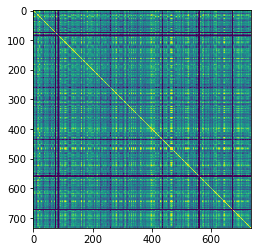

In [221]:
fig,ax = plt.subplots()

_dff2 = sess.timeseries['dff2'][:,nanmask]
_dff2/= np.linalg.norm(_dff2,2,axis=-1,keepdims=True)
_sm = np.matmul(_dff2,_dff2.T)
ax.imshow(_sm,vmin=np.percentile(_sm,10),vmax=np.percentile(_sm,90))

(734,) (24789,)
(18943, 734)


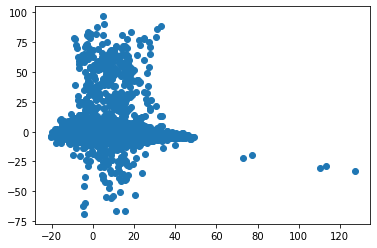

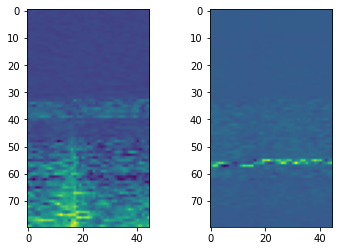

In [222]:
print(masks.shape,nanmask.shape)
_dff2 = sess.timeseries['dff2'][masks,:]
_dff2 = sess.timeseries['dff2'][:,nanmask]
pca = sklearn.decomposition.PCA()
_dff2_red = pca.fit_transform(_dff2.T)
print(_dff2_red.shape)
fig,ax = plt.subplots()
ax.scatter(_dff2_red[:,3],_dff2_red[:,4])

_dff2_red_full = np.zeros(sess.timeseries['dff2'].shape)*np.nan
_dff2_red_full[:,nanmask]=_dff2_red.T

_dff2_red_mats = TwoPUtils.spatial_analyses.trial_matrix(_dff2_red_full.T,
                                                        sess.vr_data['pos']._values, 
                                                        sess.trial_start_inds,
                                                        sess.teleport_inds,
                                                        mat_only=True)

fig,ax = plt.subplots(1,2)
ax[0].imshow(_dff2_red_mats[:,:,3])
ax[1].imshow(_dff2_red_mats[:,:,4])

(734, 45)


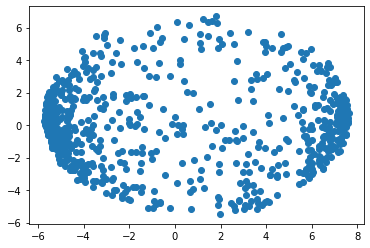

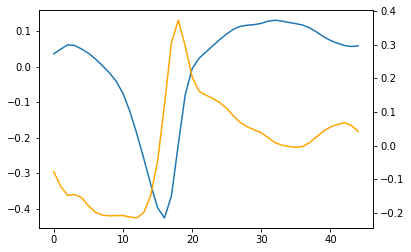

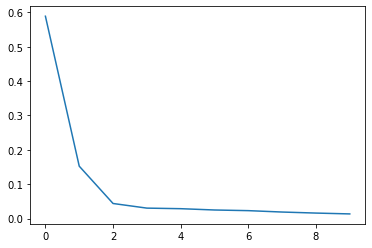

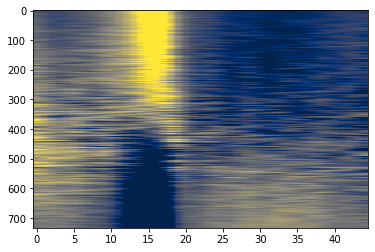

In [224]:
_dff2 = np.nanmean(sess.trial_matrices['dff2'][0],axis=0)
_dff2[np.isnan(_dff2)]=0
_dff2 = sp.ndimage.filters.gaussian_filter1d(_dff2,1,axis=0)
# _dff2 /= _dff2.mean(axis=0,keepdims=True)
_dff2 = sp.stats.zscore(_dff2,axis=0)


pca = sklearn.decomposition.PCA()
_dff2_red = pca.fit_transform(_dff2.T)
print(_dff2_red.shape)
fig,ax = plt.subplots()
ax.scatter(_dff2_red[:,0],_dff2_red[:,1])
# ax.set_xlim([-1,5])
# ax.set_ylim([-1,2])

fig,ax = plt.subplots()
ax.plot(pca.components_[0,:])
ax2 = ax.twinx()
ax2.plot(pca.components_[1,:],color='orange')

fig,ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[:10])
# ax.plot(pca.singular_values_[:10]**.5)

fig,ax = plt.subplots()
ax.imshow(sp.stats.zscore(_dff2[:,np.argsort(_dff2_red[:,0])].T,axis=1),
          aspect='auto',cmap='cividis',vmin=-1,vmax=2)

rank 1
(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


rank 2
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 3
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 4
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 5
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 6
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 7
(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


rank 8
(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


rank 9
(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(45, 1553)


/home/mplitt/anaconda3/envs/InVivoDA/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Text(0, 0.5, 'reconstruction error')

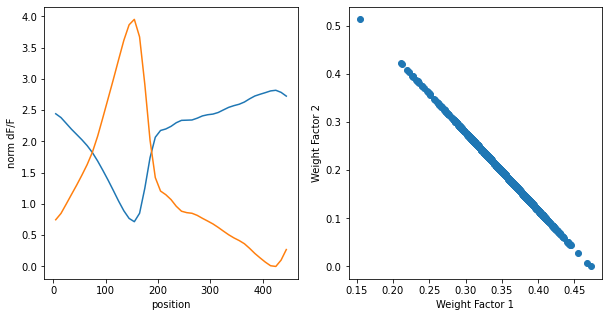

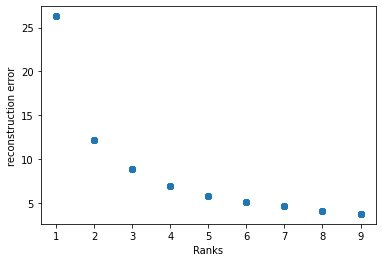

In [204]:

err = []
red = []
models = []
ranks = []

_dff2 = np.nanmean(sess.trial_matrices['dff2'][0],axis=0)
_dff2[np.isnan(_dff2)]=0
_dff2 = sp.ndimage.filters.gaussian_filter1d(_dff2,1,axis=0)
_dff2 -= np.amin(_dff2)
_dff2 /= _dff2.mean(axis=0,keepdims=True)


for n in range(1,10):
# for n in [3]:
    print('rank',n)
    for rep in range(5):
        print(_dff2.shape)
        nmf = sklearn.decomposition.NMF(n_components=n, max_iter=10000)
        _red = nmf.fit_transform(_dff2.T)
        red.append(_red)
        err.append(nmf.reconstruction_err_)
        models.append(nmf)
        ranks.append(n)
        
        if n == 2 and rep ==0 :
            fig, ax =plt.subplots(1,2,figsize=[10,5]) #1,4,figsize=[20,5])
            fig.subplots_adjust(hspace=.5)
            for _n in range(n):
                ax[0].plot(sess.trial_matrices['licks'][-1],nmf.components_[_n,:])
            ax[0].set_xlabel('position')
            ax[0].set_ylabel('norm dF/F')
            
            ax[1].scatter(_red[:,0],_red[:,1])
            ax[1].set_xlabel('Weight Factor 1')
            ax[1].set_ylabel('Weight Factor 2')
            
    
#             ax[1].scatter(_red[:,0],_red[:,1],c=_red[:,2],cmap='cool')
#             ax[2].scatter(_red[:,0],_red[:,2])
#             ax[3].scatter(_red[:,1],_red[:,2])
    
fig,ax = plt.subplots()
ax.scatter(ranks,err)
ax.set_xlabel('Ranks')
ax.set_ylabel('reconstruction error')
    

# fig, ax = plt.subplots()
# ax.scatter(_dff2_red[:,0],_dff2_red[:,1])



rank 2
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 3
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 4
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 5
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 6
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 7
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 8
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
rank 9
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)
(45, 1553)


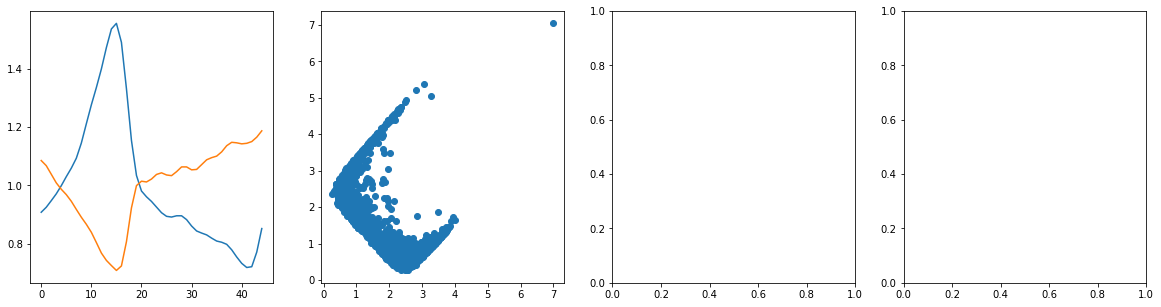

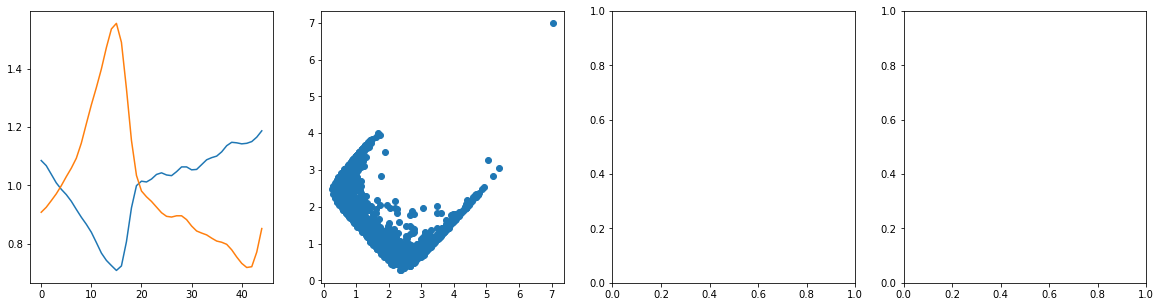

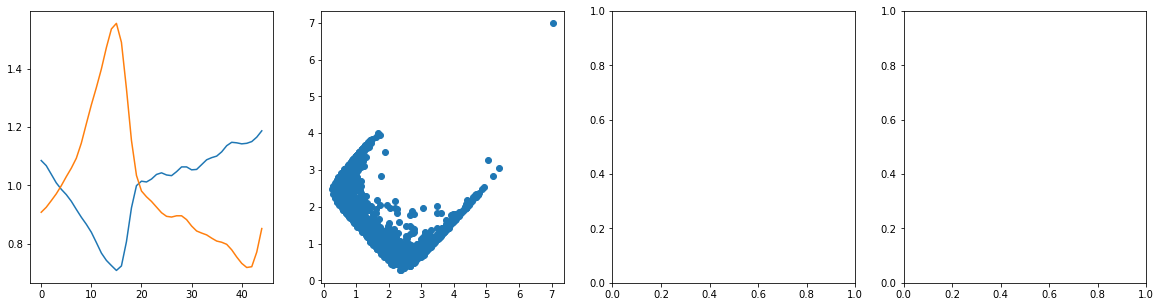

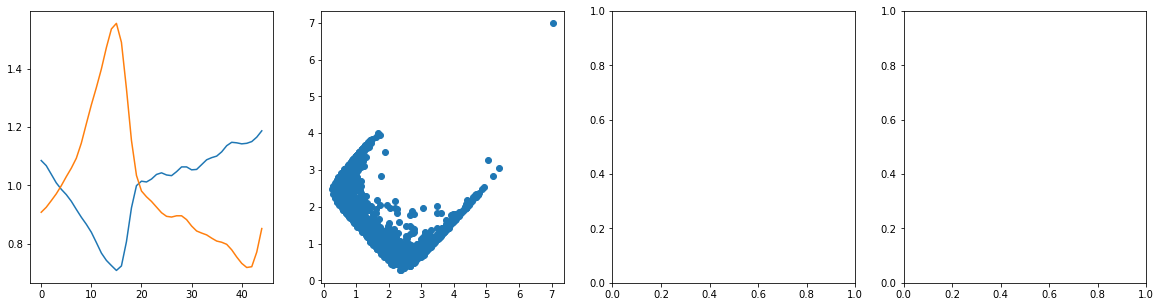

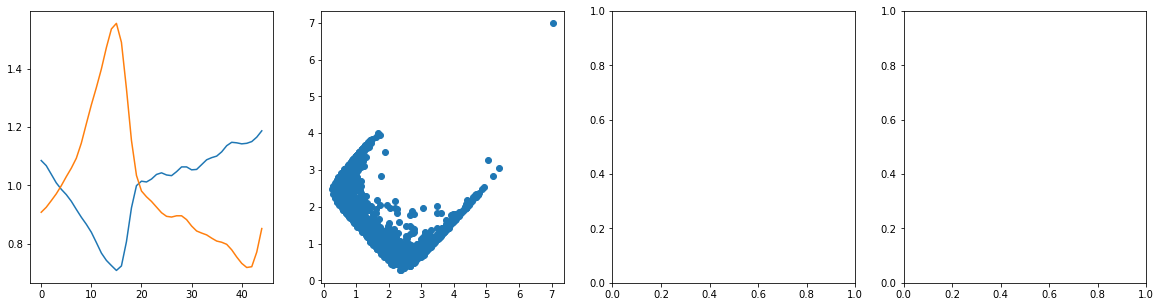

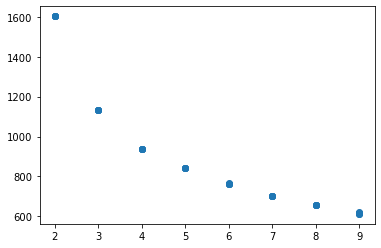

In [203]:
err = []
red = []
models = []
ranks = []

_dff2 = np.nanmean(sess.trial_matrices['dff2'][0],axis=0)
_dff2[np.isnan(_dff2)]=0
_dff2 = sp.ndimage.filters.gaussian_filter1d(_dff2,1,axis=0)
_dff2 /= _dff2.mean(axis=0,keepdims=True)


for n in range(2,10):
# for n in [3]:
    print('rank',n)
    for rep in range(5):
        print(_dff2.shape)
        mdl = sklearn.cluster.KMeans(n_clusters=n, max_iter=10000)
        _red = mdl.fit_transform(_dff2.T)
        red.append(_red)
        err.append(mdl.inertia_)
        models.append(mdl)
        ranks.append(n)
        
        if n == 2:
            fig, ax =plt.subplots(1,4,figsize=[20,5])
            for _n in range(n):
                ax[0].plot(mdl.cluster_centers_[_n,:])
            
    
            ax[1].scatter(_red[:,0],_red[:,1]) #,c=_red[:,2],cmap='cool')
#             ax[2].scatter(_red[:,0],_red[:,2])
#             ax[3].scatter(_red[:,1],_red[:,2])
    
fig,ax = plt.subplots()
ax.scatter(ranks,err)
    


In [213]:

_dff2 = np.nanmean(sess.trial_matrices['dff2'][0],axis=0)
_dff2[np.isnan(_dff2)]=0
_dff2 = sp.ndimage.filters.gaussian_filter1d(_dff2,1,axis=0)
# _dff2 /= _dff2.mean(axis=0,keepdims=True)
_dff2 = sp.stats.zscore(_dff2,axis=0)


mds = sklearn.manifold.MDS(n_components=1)
embedding = mds.fit_transform(_dff2.T)

# fig,ax = plt.subplots()
# ax.scatter(embedding[:,0],embedding[:,1])


# fig,ax = plt.subplots()
# ax.imshow(_dff2[:,np.argsort(embedding[:,1])].T,cmap='cividis',aspect='auto')

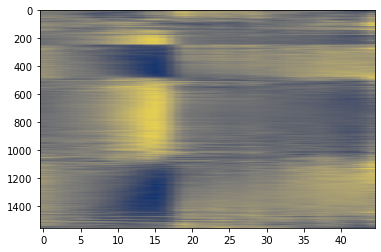

In [215]:
fig,ax = plt.subplots()
ax.imshow(_dff2[:,np.argsort(embedding[:,0])].T,cmap='cividis',aspect='auto',vmax=3,vmin=-3)
